In [44]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np
import itertools
from itertools import permutations, combinations
import time
from pylab import *

torch.manual_seed(3)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all

def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]


# ----- Step 1: Set Hyper Parameters ----- #

USING_MPCS = True

NAME = 'DNN-MNIST'
OUTPUT_CLASS = 10

RELEASE_LISTS = [
    [3,6],
    [6,3],
    [6,8],
    [8,6],
    [3,2],
    [2,3],
    [3,5],
    [5,3],
    [5,8],
    [8,5],
    [2,5],
    [5,2],
    [1,2],
    [2,1],
    [7,8],
    [8,7],
    [7,9],
    [9,7],
    [5,9],
    [9,5],
    [9,4],
    [4,9],
    [4,6],
    [6,4],
    [6,0],
    [0,6],
    [1,0],
    [0,1]
]
RELEASE_FACTOR = 0.5

LR = 0.01
BATCH_SIZE = 64

TURNS = 150

K = 5
T = 200

K_release = K-1
T_max = T-1


# ----- Step 2: Load MNIST Dataset and Create Loader ----- #

train_data = dsets.MNIST(root='../Datasets', train=True, transform=transforms.ToTensor(), download=True)
test_data = dsets.MNIST(root='../Datasets', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_X = train_data.train_data.type(torch.FloatTensor)/255.
train_Y = train_data.train_labels.numpy()
test_X = test_data.test_data.type(torch.FloatTensor)/255.
test_Y = test_data.test_labels.numpy()

train_Y1 = train_data.train_labels.type(torch.LongTensor)

y_train_onehot = torch.nn.functional.one_hot(train_Y1)


# ----- Step 3: Create Model Class ----- #

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(784, 32)
        self.l2 = torch.nn.Linear(32, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.l1(x))
        return self.l2(x)


# ----- Step 4: Instantiate ----- #

model = Net()
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MS_loss_fn = torch.nn.MSELoss()


# ----- Step 5: Model Training ----- #

turns_record = []
loss_record = []
MS_loss_record = []
train_acc_record = []
F1_record = []
MCC_record = []
Score_record = []
test_acc_record = []
destructive_num_record = []

turns_index = 0
for turns in range(1, 2):
    for batch_idx, data in enumerate(train_loader, 0):
        turns_index += 1
    
        # Shared Part - train_output
        train_output = model(train_X)

        # Shared Part - softmax
        train_output_result = F.softmax(train_output, dim=1)  # softmax in last dim

        # Shared Part - pred_train_y
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()

        # Acc
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)

        # MS Loss
        MS_train_loss = MS_loss_fn(train_output_result, y_train_onehot)

        # CE Loss
        train_loss = loss_fn(train_output, train_Y1)

        # F1
        F1 = f1_score(train_Y, pred_train_y, average='macro')

        # MCC
        MCC = matthews_corrcoef(train_Y, pred_train_y)

        # Score
        output_results = train_output_result.detach().numpy()
        prediction_pattern = np.argsort(-output_results)[:, :K]  # sorted_states_index
        confidence_pattern = T_max - np.floor((-np.sort(-output_results)[:, :K]) * T)  # sorted_states_t
        confidence_pattern[confidence_pattern == -1] = 0

        total_score = 0
        pattern_num = len(confidence_pattern)
        release_factors = np.ones((pattern_num, K))

        for i in range(pattern_num):
            current_prediction_pattern = list(prediction_pattern[i])
            if train_Y[i] in current_prediction_pattern:
                correct_index = current_prediction_pattern.index(train_Y[i])
                confidence_pattern[i][correct_index] = T_max - confidence_pattern[i][correct_index]
                release_factors[i][correct_index] = K_release

                for release_list in RELEASE_LISTS:
                    if current_prediction_pattern[correct_index] == release_list[0]:
                        for j in range(K):
                            if j != correct_index and current_prediction_pattern[j] in release_list[1:]:
                                release_factors[i][j] = RELEASE_FACTOR

        release_factors /= release_factors.sum(axis=1).reshape(-1,1)
        confidence_pattern[confidence_pattern == 0] = 1e-7
        confidence_pattern = -np.log(confidence_pattern / T_max)
        total_score = (np.multiply(release_factors, confidence_pattern).sum()) / pattern_num

        # (Test Acc)
        test_output = model(test_X)
        pred_test_y = torch.max(test_output, 1)[1].data.numpy()
        test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)
        
        # Number of Destructive Samples
        mt = np.zeros((10,10)).astype(int)
        for i in range(len(pred_train_y)):
            xx = int(pred_train_y[i])
            yy = int(train_Y[i])
            mt[xx][yy] += 1
        correct_num = 0
        for i in range(10):
            correct_num += mt[i][i]
        release_num = 0
        for i in range(len(RELEASE_LISTS)):
            release_num += mt[RELEASE_LISTS[i][0]][RELEASE_LISTS[i][1]]
        bad_num = len(pred_train_y) - correct_num - release_num    

        print('TURNS ID: ', turns_index, '| Acc: %.4f' % train_accuracy, '| F1: %.4f' % F1, '| MCC: %.4f' % MCC, 
              '| MS Loss: %.4f' % MS_train_loss.data.numpy(), '| CE Loss: %.4f' % train_loss.data.numpy(), 
              '| Score: %.4f' % total_score, '| Test: %.4f' % test_accuracy)

        turns_record.append(turns_index)
        loss_record.append(train_loss.data.numpy())
        MS_loss_record.append(MS_train_loss.data.numpy())
        train_acc_record.append(train_accuracy)
        F1_record.append(F1)
        MCC_record.append(MCC)
        Score_record.append(total_score)
        test_acc_record.append(test_accuracy)
        destructive_num_record.append(bad_num)
        
        inputs, target = data
        optimizer.zero_grad()  # clear gradients for this training step
        outputs = model(inputs)
        if USING_MPCS == True:
            loss = total_score * loss_fn(outputs, target)
        else:
            loss = loss_fn(outputs, target)
        loss.backward()        # backward and compute gradients
        optimizer.step()       # apply gradients
        
        if turns_index >= 300:
            break


np.save(f'../Records/{USING_MPCS}_TrainAcc.npy', train_acc_record)
np.save(f'../Records/{USING_MPCS}_TestAcc.npy', test_acc_record)
np.save(f'../Records/{USING_MPCS}_MPCS.npy', Score_record)
np.save(f'../Records/{USING_MPCS}_DesNum.npy', destructive_num_record)


C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\thinkpad\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Net(
  (l1): Linear(in_features=784, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=10, bias=True)
)
TURNS ID:  1 | Acc: 0.0799 | F1: 0.0550 | MCC: -0.0271 | MS Loss: 0.0901 | CE Loss: 2.3055 | Score: 0.7183 | Test: 0.0798
TURNS ID:  2 | Acc: 0.2326 | F1: 0.1238 | MCC: 0.1804 | MS Loss: 0.0872 | CE Loss: 2.1901 | Score: 0.7992 | Test: 0.2346
TURNS ID:  3 | Acc: 0.4661 | F1: 0.3866 | MCC: 0.4334 | MS Loss: 0.0830 | CE Loss: 2.0265 | Score: 0.8477 | Test: 0.4589
TURNS ID:  4 | Acc: 0.5444 | F1: 0.4542 | MCC: 0.5124 | MS Loss: 0.0771 | CE Loss: 1.8538 | Score: 0.8046 | Test: 0.5411
TURNS ID:  5 | Acc: 0.5163 | F1: 0.4246 | MCC: 0.4858 | MS Loss: 0.0721 | CE Loss: 1.6950 | Score: 0.8547 | Test: 0.5158
TURNS ID:  6 | Acc: 0.5423 | F1: 0.4707 | MCC: 0.5129 | MS Loss: 0.0677 | CE Loss: 1.5539 | Score: 0.8466 | Test: 0.5390
TURNS ID:  7 | Acc: 0.6140 | F1: 0.5618 | MCC: 0.5853 | MS Loss: 0.0625 | CE Loss: 1.4120 | Score: 0.7866 | Test: 0.6135
TURNS ID:  8 | Acc: 0.6851

TURNS ID:  68 | Acc: 0.8766 | F1: 0.8754 | MCC: 0.8634 | MS Loss: 0.0186 | CE Loss: 0.4134 | Score: 0.2611 | Test: 0.8777
TURNS ID:  69 | Acc: 0.8782 | F1: 0.8768 | MCC: 0.8651 | MS Loss: 0.0183 | CE Loss: 0.4064 | Score: 0.2587 | Test: 0.8786
TURNS ID:  70 | Acc: 0.8825 | F1: 0.8809 | MCC: 0.8699 | MS Loss: 0.0177 | CE Loss: 0.3935 | Score: 0.2530 | Test: 0.8824
TURNS ID:  71 | Acc: 0.8871 | F1: 0.8852 | MCC: 0.8748 | MS Loss: 0.0171 | CE Loss: 0.3819 | Score: 0.2457 | Test: 0.8874
TURNS ID:  72 | Acc: 0.8883 | F1: 0.8862 | MCC: 0.8761 | MS Loss: 0.0169 | CE Loss: 0.3772 | Score: 0.2452 | Test: 0.8890
TURNS ID:  73 | Acc: 0.8884 | F1: 0.8862 | MCC: 0.8763 | MS Loss: 0.0168 | CE Loss: 0.3764 | Score: 0.2458 | Test: 0.8900
TURNS ID:  74 | Acc: 0.8880 | F1: 0.8856 | MCC: 0.8757 | MS Loss: 0.0169 | CE Loss: 0.3775 | Score: 0.2462 | Test: 0.8910
TURNS ID:  75 | Acc: 0.8869 | F1: 0.8845 | MCC: 0.8746 | MS Loss: 0.0170 | CE Loss: 0.3801 | Score: 0.2491 | Test: 0.8911
TURNS ID:  76 | Acc: 0.8

TURNS ID:  135 | Acc: 0.9104 | F1: 0.9093 | MCC: 0.9005 | MS Loss: 0.0136 | CE Loss: 0.3044 | Score: 0.1992 | Test: 0.9123
TURNS ID:  136 | Acc: 0.9091 | F1: 0.9081 | MCC: 0.8991 | MS Loss: 0.0138 | CE Loss: 0.3075 | Score: 0.2019 | Test: 0.9122
TURNS ID:  137 | Acc: 0.9046 | F1: 0.9037 | MCC: 0.8943 | MS Loss: 0.0144 | CE Loss: 0.3166 | Score: 0.2083 | Test: 0.9090
TURNS ID:  138 | Acc: 0.9003 | F1: 0.8994 | MCC: 0.8896 | MS Loss: 0.0149 | CE Loss: 0.3274 | Score: 0.2167 | Test: 0.9044
TURNS ID:  139 | Acc: 0.8964 | F1: 0.8953 | MCC: 0.8854 | MS Loss: 0.0154 | CE Loss: 0.3356 | Score: 0.2248 | Test: 0.9011
TURNS ID:  140 | Acc: 0.8946 | F1: 0.8934 | MCC: 0.8836 | MS Loss: 0.0156 | CE Loss: 0.3408 | Score: 0.2299 | Test: 0.8988
TURNS ID:  141 | Acc: 0.8931 | F1: 0.8915 | MCC: 0.8819 | MS Loss: 0.0159 | CE Loss: 0.3455 | Score: 0.2346 | Test: 0.8966
TURNS ID:  142 | Acc: 0.8943 | F1: 0.8925 | MCC: 0.8832 | MS Loss: 0.0158 | CE Loss: 0.3441 | Score: 0.2338 | Test: 0.8971
TURNS ID:  143 |

In [51]:
USING_MPCS = True
train_acc_record = np.load(f'../Records/{USING_MPCS}_TrainAcc.npy')
test_acc_record = np.load(f'../Records/{USING_MPCS}_TestAcc.npy')
MPCS_record = np.load(f'../Records/{USING_MPCS}_MPCS.npy')
destructive_num_record = np.load(f'../Records/{USING_MPCS}_DesNum.npy')

USING_MPCS = False
ori_train_acc_record = np.load(f'../Records/{USING_MPCS}_TrainAcc.npy')
ori_test_acc_record = np.load(f'../Records/{USING_MPCS}_TestAcc.npy')
ori_MPCS_record = np.load(f'../Records/{USING_MPCS}_MPCS.npy')
ori_destructive_num_record = np.load(f'../Records/{USING_MPCS}_DesNum.npy')


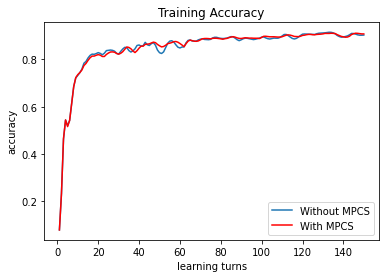

In [52]:
plt.plot(turns_record, ori_train_acc_record, color='#1f77b4', label='Without MPCS')
plt.plot(turns_record, train_acc_record, color='red', label='With MPCS')
plt.title(f"Training Accuracy")
plt.xlabel("learning turns")
plt.ylabel("accuracy")
plt.legend()
# plt.savefig(f'C:/Users/thinkpad/Desktop/MPCS论文/figNew/TrainAcc.png', bbox_inches='tight', dpi=600)
plt.show()

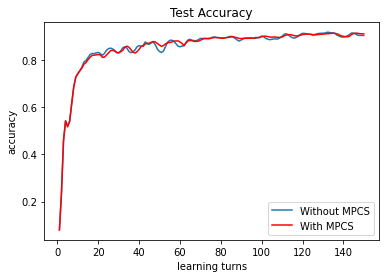

In [53]:
plt.plot(turns_record, ori_test_acc_record, color='#1f77b4', label='Without MPCS')
plt.plot(turns_record, test_acc_record, color='red', label='With MPCS')
plt.title(f"Test Accuracy")
plt.xlabel("learning turns")
plt.ylabel("accuracy")
plt.legend()
# plt.savefig(f'C:/Users/thinkpad/Desktop/MPCS论文/figNew/TestAcc.png', bbox_inches='tight', dpi=600)
plt.show()

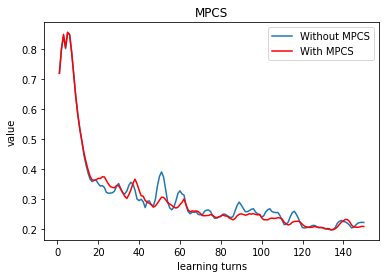

In [54]:
plt.plot(turns_record, ori_MPCS_record, color='#1f77b4', label='Without MPCS')
plt.plot(turns_record, MPCS_record, color='red', label='With MPCS')
plt.title(f"MPCS")
plt.xlabel("learning turns")
plt.ylabel("value")
plt.legend()
# plt.savefig(f'C:/Users/thinkpad/Desktop/MPCS论文/figNew/MPCS.png', bbox_inches='tight', dpi=600)
plt.show()

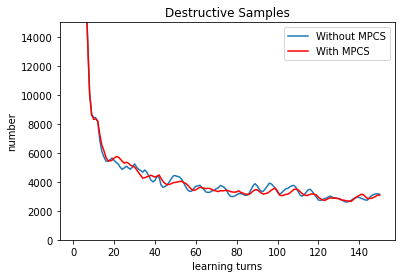

In [55]:
plt.plot(turns_record, ori_destructive_num_record, color='#1f77b4', label='Without MPCS')
plt.plot(turns_record, destructive_num_record, color='red', label='With MPCS')
plt.title(f"Destructive Samples")
plt.xlabel("learning turns")
plt.ylabel("number")
plt.ylim(0,15000)
plt.legend()
# plt.savefig(f'C:/Users/thinkpad/Desktop/MPCS论文/figNew/DesNum.png', bbox_inches='tight', dpi=600)
plt.show()

In [56]:
print(f'TrainAcc: {sum(train_acc_record)/sum(ori_train_acc_record)}')
print(f'TestAcc: {sum(test_acc_record)/sum(ori_test_acc_record)}')
print(f'MPCS: {sum(MPCS_record)/sum(ori_MPCS_record)}')
print(f'DesNum: {sum(destructive_num_record)/sum(ori_destructive_num_record)}')


TrainAcc: 1.0004345508164298
TestAcc: 1.000262675458998
MPCS: 0.983766400808319
DesNum: 0.9964012035597529
